In [1]:
import os
import sys
import json
import argparse

import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

from glob import glob
from nilearn import plotting

In [2]:

# ### import data with `pybids` 
# based on: https://github.com/bids-standard/pybids/blob/master/examples/pybids_tutorial.ipynb
def import_bids_data(bidsroot, subject_id, task_label):
    from bids import BIDSLayout

    layout = BIDSLayout(bidsroot)

    all_files = layout.get()
    t1w_fpath = layout.get(return_type='filename', subject=subject_id, 
                            suffix='T1w', extension='nii.gz')[0]
    bold_files = layout.get(return_type='filename', subject=subject_id, 
                            suffix='bold', task=task_label, extension='nii.gz')
    return all_files, t1w_fpath, bold_files



In [3]:

# ## nilearn modeling: first level
# based on: https://nilearn.github.io/auto_examples/04_glm_first_level/plot_bids_features.html#sphx-glr-auto-examples-04-glm-first-level-plot-bids-features-py

def prep_models_and_args(subject_id=None, task_id=None, fwhm=None, bidsroot=None, 
                         deriv_dir=None, event_type=None, t_r=None, t_acq=None, space_label='T1w'):
    from nilearn.glm.first_level import first_level_from_bids
    from nilearn.interfaces.fmriprep import load_confounds

    data_dir = bidsroot

    task_label = task_id
    fwhm_sub = fwhm

    # correct the fmriprep-given slice reference (middle slice, or 0.5)
    # to account for sparse acquisition (silent gap during auditory presentation paradigm)
    # fmriprep is explicitly based on slice timings, while nilearn is based on t_r
    # and since images are only collected during a portion of the overall t_r (which includes the silent gap),
    # we need to account for this
    slice_time_ref = 0.5 * t_acq / t_r

    print(data_dir, task_label, space_label)

    models, models_run_imgs, models_events, models_confounds = first_level_from_bids(data_dir, task_label, space_label,
                                                                                     [subject_id],
                                                                                     smoothing_fwhm=fwhm,
                                                                                     derivatives_folder=deriv_dir,
                                                                                     slice_time_ref=slice_time_ref,
                                                                                     minimize_memory=False)

    # fill n/a with 0
    [[mc.fillna(0, inplace=True) for mc in sublist] for sublist in models_confounds]

    # define which confounds to keep as nuisance regressors
    conf_keep_list = ['framewise_displacement',
    #                #'a_comp_cor_00', 'a_comp_cor_01', 
    #                #'a_comp_cor_02', 'a_comp_cor_03', 
    #                #'a_comp_cor_04', 'a_comp_cor_05', 
    #                #'a_comp_cor_06', 'a_comp_cor_07', 
    #                #'a_comp_cor_08', 'a_comp_cor_09', 
                    'trans_x', 'trans_y', 'trans_z', 
                    'rot_x','rot_y', 'rot_z']

    ''' create events '''
    for sx, sub_events in enumerate(models_events):
        print(models[sx].subject_label)
        for mx, run_events in enumerate(sub_events):
            # block design
            if event_type == 'block_stim':
                run_events = run_events.groupby('trial_type', sort=False, as_index=False).first()
                run_events.drop(run_events[run_events.trial_type=='null'].index, inplace=True)
                run_events.duration = 20
        
            if event_type == 'block_sound':
                run_events = run_events.groupby('trial_type', sort=False, as_index=False).first()
                run_events.drop(run_events[run_events.trial_type=='null'].index, inplace=True)
                run_events.duration = 20
                run_events.trial_type = 'sound'
    
            # stimulus events
            if event_type == 'stimulus':
                name_groups = run_events.groupby('trial_type')['trial_type']
                suffix = name_groups.cumcount() + 1
                repeats = name_groups.transform('size')

                run_events['trial_type'] = run_events['trial_type']
                run_events['trial_type'] = run_events['trial_type'].str.replace('-','_')

            # trial-specific events          
            if event_type == 'trial':
                name_groups = run_events.groupby('trial_type')['trial_type']
                suffix = name_groups.cumcount() + 1
                repeats = name_groups.transform('size')

                run_events['trial_type'] = run_events['trial_type'] + \
                                                    '_trial' + suffix.map(str)
                run_events['trial_type'] = run_events['trial_type'].str.replace('-','_')

            # all sound events
            elif event_type == 'sound':
                orig_stim_list = sorted([str(s) for s in run_events['trial_type'].unique() 
                                         if str(s) not in ['nan', 'None', 'null']])
                #print('original stim list: ', orig_stim_list)

                run_events['trial_type'] = run_events.trial_type.str.split('_', expand=True)[0]

            # re-assign to models_events
            models_events[sx][mx] = run_events
            
        # create stimulus list from updated events.tsv file
        stim_list = sorted([str(s) for s in run_events['trial_type'].unique() if str(s) not in ['nan', 'None']])
    
    print('stim list: ', stim_list)
    #model_and_args = zip(models, models_run_imgs, models_events, models_confounds)
    return stim_list, models, models_run_imgs, models_events, models_confounds, conf_keep_list



In [4]:

# ### Across-runs GLM
def nilearn_glm_across_runs(stim_list, task_label, models, models_run_imgs, \
                            models_events, models_confounds, conf_keep_list, space_label):
    from nilearn.reporting import make_glm_report
    for midx in range(len(models)):
        for sx, stim in enumerate(stim_list):
            contrast_label = stim
            contrast_desc  = stim


            midx = 0
            model = models[midx]
            imgs = models_run_imgs[midx]
            events = models_events[midx]
            confounds = models_confounds[midx]

            print(model.subject_label)

            # set limited confounds
            print('selecting confounds')
            confounds_ltd = [models_confounds[midx][cx][conf_keep_list] for cx in range(len(models_confounds[midx]))]
            
            #try:
            # fit the GLM
            print('fitting GLM')
            model.fit(imgs, events, confounds_ltd);

            # compute the contrast of interest
            print('computing contrast of interest')
            summary_statistics = model.compute_contrast(contrast_label, output_type='all')
            zmap = summary_statistics['z_score']
            tmap = summary_statistics['stat']
            statmap = summary_statistics['effect_size']

            # get the residuals

            # save z map
            print('saving z-map')
            nilearn_sub_dir = os.path.join(bidsroot, 'derivatives', 'nilearn', 
                                        'level-1_fwhm-%.02f'%model.smoothing_fwhm, 
                                        'sub-%s_space-%s'%(model.subject_label, space_label),
                                        'run-all')
            if not os.path.exists(nilearn_sub_dir):
                os.makedirs(nilearn_sub_dir)

            analysis_prefix = 'sub-%s_task-%s_fwhm-%.02f_space-%s_contrast-%s'%(model.subject_label,
                                                                                task_label, model.smoothing_fwhm,
                                                                                space_label, contrast_desc)
            zmap_fpath = os.path.join(nilearn_sub_dir,
                                    analysis_prefix+'_zmap.nii.gz')
            nib.save(zmap, zmap_fpath)
            print('saved z map to ', zmap_fpath)

            tmap_fpath = os.path.join(nilearn_sub_dir,
                                    analysis_prefix+'_map-tstat.nii.gz')
            nib.save(tmap, tmap_fpath)
            print('saved t map to ', tmap_fpath)

            # also save beta maps
            statmap_fpath = os.path.join(nilearn_sub_dir,
                                        analysis_prefix+'_map-beta.nii.gz')
            nib.save(statmap, statmap_fpath)
            print('saved beta map to ', statmap_fpath)

            # save report
            print('saving report')
            report_fpath = os.path.join(nilearn_sub_dir,
                                        analysis_prefix+'_report.html')
            report = make_glm_report(model=model,
                                    contrasts=contrast_label)
            report.save_as_html(report_fpath)
            print('saved report to ', report_fpath)
            #except:
            #    print('could not run for ', contrast_label)
    return zmap_fpath, statmap_fpath, contrast_label,


In [6]:
def plot_stat_maps(zmap, nilearn_dir, p_val=0.005):
    from scipy.stats import norm
    thresh_unc = norm.isf(p_val)

    # plot
    fig, axes = plt.subplots(3, 1, figsize=(20, 15))
    plotting.plot_stat_map(zmap, bg_img=t1w_fpath, colorbar=True, threshold=thresh_unc,
                        title='sub-%s %s (unc p<%.03f; fwhm=%.02f)'%(model.subject_label, 
                                                                    contrast_label ,p_val,fwhm_sub),
                        axes=axes[0],
                        display_mode='x', cut_coords=6)
    plotting.plot_stat_map(zmap, bg_img=t1w_fpath, colorbar=True, threshold=thresh_unc,
                        axes=axes[1],
                        display_mode='y', cut_coords=6)
    plotting.plot_stat_map(zmap, bg_img=t1w_fpath, colorbar=True, threshold=thresh_unc,
                        axes=axes[2],
                        display_mode='z', cut_coords=6)
    plotting.show()

    # save plot
    plot_fpath = os.path.join(nilearn_dir, 
                            'sub-%s_task-%s_fwhm-%.02f_pval-%.03f_space-%s_contrast-%s.png'%(model.subject_label,
                                                                        task_label,fwhm_sub, p_val,
                                                                        space_label, contrast_desc))
    fig.savefig(plot_fpath)

    return plot_fpath

In [7]:
# ## plot tsnr
def plot_tsnr(bold_files):
    from nilearn import image

    thresh = 0
    fwhm = 5

    for fx,filepath in enumerate(bold_files):
        tsnr_func = image.math_img('img.mean(axis=3) / img.std(axis=3)', img=filepath)
        tsnr_func_smooth = image.smooth_img(tsnr_func, fwhm=5)

        display = plotting.plot_stat_map(tsnr_func_smooth, 
                                        bg_img=t1w_fpath, 
                                        #title='fMRI single run tSNR map',
                                        #cut_coords=[8,50,-20],
                                        #threshold=thresh, 
                                        #cmap='jet'
                                        );
        display.show()
        

In [8]:
def mask_fmri(fmri_niimgs, mask_filename, fwhm):
    from nilearn.maskers import NiftiMasker
    masker = NiftiMasker(mask_img=mask_filename, 
                         smoothing_fwhm=fwhm, standardize=True,
                         memory="nilearn_cache", memory_level=1)
    fmri_masked = masker.fit_transform(fmri_niimgs)
    return fmri_masked, masker

## Run pipelines

In [9]:
task_label = 'stgrid'
t_acq = 2
t_r = 4

project_dir = os.path.join('/bgfs/bchandrasekaran/krs228/data/', 'FLT/')
#bidsroot = os.path.join(project_dir,'data_bids')
bidsroot = os.path.join(project_dir,'data_bids_noIntendedFor')
deriv_dir = os.path.join(project_dir, 'derivatives', 'fmriprep_noSDC')

nilearn_dir = os.path.join(bidsroot, 'derivatives', 'nilearn')
if not os.path.exists(nilearn_dir):
        os.makedirs(nilearn_dir)

### Univariate analysis

In [10]:
fwhm = 3
event_type = 'block_sound'
space_label = 'MNI152NLin2009cAsym'
subject_list = ['FLT08', ] # 
# 'FLT01', 'FLT02', 'FLT03', 'FLT04', 'FLT05', 'FLT06', 'FLT07', 'FLT08', 'FLT09', 'FLT10', 'FLT11', 'FLT12', 'FLT13',

In [36]:
for sx, subject_id in enumerate(subject_list):
    print('Running subject ', subject_id)
    stim_list, models, models_run_imgs, \
        models_events, models_confounds, conf_keep_list = prep_models_and_args(subject_id, task_label, 
                                                                                 fwhm, bidsroot, 
                                                                                 deriv_dir, event_type,
                                                                                 t_r, t_acq, 
                                                                                 space_label)
    # Across-run GLM
    zmap_fpath, statmap_fpath, contrast_label = nilearn_glm_across_runs(stim_list, task_label, 
                                                                        models, models_run_imgs, 
                                                                        models_events, models_confounds, 
                                                                        conf_keep_list, space_label)

Running subject  FLT08
/bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor stgrid MNI152NLin2009cAsym
FLT08
stim list:  ['sound']
FLT08
selecting confounds
fitting GLM


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `Unnamed: 0` in events d

computing contrast of interest


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


saving z-map
saved z map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT08_space-MNI152NLin2009cAsym/run-all/sub-FLT08_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-sound_zmap.nii.gz
saved t map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT08_space-MNI152NLin2009cAsym/run-all/sub-FLT08_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-sound_map-tstat.nii.gz
saved beta map to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT08_space-MNI152NLin2009cAsym/run-all/sub-FLT08_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-sound_map-beta.nii.gz
saving report


/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


saved report to  /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT08_space-MNI152NLin2009cAsym/run-all/sub-FLT08_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-sound_report.html


In [ ]:
ls /bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/nilearn/level-1_fwhm-3.00/sub-FLT08_space-MNI152NLin2009cAsym/run-all/*task-stgrid*sound*zmap*

In [ ]:
test_zmap_fpath = ('/bgfs/bchandrasekaran/krs228/data/FLT/data_bids_noIntendedFor/derivatives/'
             'nilearn/level-1_fwhm-3.00/sub-FLT08_space-MNI152NLin2009cAsym/run-all/'
             'sub-FLT08_task-stgrid_fwhm-3.00_space-MNI152NLin2009cAsym_contrast-stim_10_zmap.nii.gz')

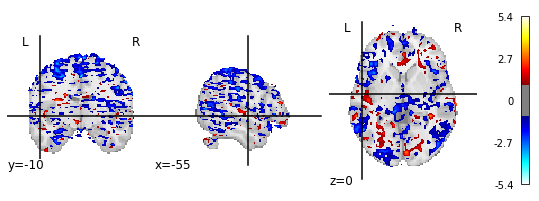

In [39]:
plotting.plot_stat_map(zmap_fpath, threshold=1, cut_coords=[-55,-10,0])

### Multivariate analysis

Three options for multivariate analysis:
1. across-run stimulus modeling (n_output = n_stimuli)
2. within-run stimulus modeling (n_output = n_stimuli x n_runs)
3. within-run trial modeling (n_output = n_trials x n_runs)

In [ ]:
space_label = 'MNI152NLin2009cAsym'
subject_list = ['FLT01', 'FLT02', 'FLT03', 'FLT04', 'FLT05', 'FLT06', 'FLT07', 'FLT08', 'FLT09', 'FLT10', 'FLT11', 'FLT12', 'FLT13',]
fwhm_sub = 0

In [ ]:
print(subject_list)
print('analysis space: ', space_label)
print('task: ', task_label)
print('bids root directory: ', bidsroot)
print('derivatives directory: ', deriv_dir)

#### Stimulus modeling (across-run estimates)

In [ ]:
# Multivariate analysis: across-run GLM
event_type = 'stimulus'
event_filter = 'sound' 
for subject_id in subject_list:
    print('running with subject ', subject_id)

    stim_list, models, models_run_imgs, \
        models_events, models_confounds, conf_keep_list = prep_models_and_args(subject_id, task_label, fwhm_sub, bidsroot, 
                                                                               deriv_dir, event_type, t_r, t_acq, 
                                                                               space_label=space_label)
    print('stim list: ', stim_list)
    statmap_fpath, contrast_label = nilearn_glm_across_runs(stim_list, task_label, event_filter, models, models_run_imgs, 
                                                     models_events, models_confounds, conf_keep_list, space_label)
    #stat_maps, conditions = generate_conditions(subject_id, fwhm, space_label, deriv_dir)

#### Stimulus modeling: within-run GLM

In [ ]:
# Multivariate analysis: within-run GLM
event_type = 'stimulus'
event_filter = 'sound'
for subject_id in subject_list:
    print('running with subject ', subject_id)
        
    stim_list, models, models_run_imgs, \
        models_events, models_confounds, conf_keep_list = prep_models_and_args(subject_id, task_label, fwhm_sub, bidsroot, 
                                                                               deriv_dir, event_type, t_r, t_acq, 
                                                                               space_label=space_label)
    print('stim list: ', stim_list)
    statmap_fpath, contrast_label = nilearn_glm_per_run(stim_list, task_label, event_filter, models, models_run_imgs, 
                                                     models_events, models_confounds, conf_keep_list, space_label)
    #stat_maps, conditions = generate_conditions(subject_id, fwhm, space_label, deriv_dir)

#### Single trial modeling (within-run GLM)

Takes approximately 4–6 hours per subject

In [ ]:
# Multivariate analysis: within-run GLM
event_type = 'trial'
event_filter = 'sound'
for subject_id in subject_list:
    print('running with subject ', subject_id)
        
    stim_list, models, models_run_imgs, \
        models_events, models_confounds, conf_keep_list = prep_models_and_args(subject_id, task_label, fwhm_sub, bidsroot, 
                                                                               deriv_dir, event_type, t_r, t_acq, 
                                                                               space_label=space_label)
    print('stim list: ', stim_list)
    statmap_fpath, contrast_label = nilearn_glm_per_run(stim_list, task_label, event_filter, models, models_run_imgs, 
                                                     models_events, models_confounds, conf_keep_list, space_label)
    #stat_maps, conditions = generate_conditions(subject_id, fwhm, space_label, deriv_dir)

## Second-level analyses

Based on [nilearn documentation](https://nilearn.github.io/stable/auto_examples/05_glm_second_level/plot_thresholding.html#statistical-testing-of-a-second-level-analysis)

In [ ]:
import pandas as pd

In [ ]:
sub_list_mand = ['FLT01', 'FLT03', 'FLT05', 'FLT07', 'FLT08', 'FLT10', ]

sub_list_nman = ['FLT02', 'FLT04', 'FLT06', 'FLT09', 'FLT11', 'FLT12', 'FLT13', ]

sub_list = sub_list_mand + sub_list_nman

In [ ]:
n_subjects = len(sub_list)
design_matrix = pd.DataFrame([1] * n_subjects, columns=['intercept'])

In [ ]:
design_mat_mand = pd.DataFrame([1] * len(sub_list_mand), columns=['intercept'])
design_mat_nman = pd.DataFrame([1] * len(sub_list_nman), columns=['intercept'])

In [ ]:
contrast_label = 'sound'
fwhm = 4.5
space_label = 'MNI152NLin2009cAsym'
l1_dir = os.path.join(bidsroot, 'derivatives', 'nilearn', 'level-1_fwhm-%.02f'%fwhm)
l1_fnames = sorted(glob(l1_dir+'/sub-*_space-%s/run-all/*%s_map-beta.nii.gz'%(space_label, contrast_label)))


In [ ]:
l1_fnames_mand = [sorted(glob(l1_dir+'/sub-%s_space-%s/run-all/*%s_map-beta.nii.gz'%(sub_id, space_label, contrast_label)))[0] for sub_id in sub_list_mand]

l1_fnames_nman = [sorted(glob(l1_dir+'/sub-%s_space-%s/run-all/*%s_map-beta.nii.gz'%(sub_id, space_label, contrast_label)))[0] for sub_id in sub_list_nman]

Mandarin-speaking group:

In [ ]:
from nilearn.glm.second_level import SecondLevelModel
second_level_model = SecondLevelModel().fit(l1_fnames_mand, design_matrix=design_mat_mand)

z_map = second_level_model.compute_contrast(output_type='z_score')

from nilearn.image import threshold_img
threshold = 2.58
cthresh=0
thresholded_map = threshold_img(
    z_map,
    threshold=threshold,
    cluster_threshold=cthresh,
    two_sided=True,
)

plotting.plot_stat_map(
    thresholded_map, cut_coords=[17,12,5], 
    title='Mand %s > baseline thresholded z map, z > %.02f, clusters > %d voxels'%(contrast_label, threshold, cthresh))

Non-Mandarin speaking group:

In [ ]:
from nilearn.glm.second_level import SecondLevelModel
second_level_model = SecondLevelModel().fit(l1_fnames_nman, design_matrix=design_mat_nman)

z_map = second_level_model.compute_contrast(output_type='z_score')

from nilearn.image import threshold_img
threshold = 2.58
cthresh=0
thresholded_map = threshold_img(
    z_map,
    threshold=threshold,
    cluster_threshold=cthresh,
    two_sided=True,
)

plotting.plot_stat_map(
    thresholded_map, cut_coords=[17,12,5], 
    title='Non-Mand %s > baseline thresholded z map, z > %.02f, clusters > %d voxels'%(contrast_label, threshold, cthresh))

All participants

In [ ]:
from nilearn.glm.second_level import SecondLevelModel
second_level_model = SecondLevelModel().fit(l1_fnames, design_matrix=design_matrix)

z_map = second_level_model.compute_contrast(output_type='z_score')

from nilearn import plotting
display = plotting.plot_stat_map(z_map, title='Raw z map - %s > baseline'%contrast_label)

In [ ]:
from nilearn.image import threshold_img
threshold = 2.58
cthresh=10
thresholded_map = threshold_img(
    z_map,
    threshold=threshold,
    cluster_threshold=cthresh,
    two_sided=True,
)

plotting.plot_stat_map(
    thresholded_map, cut_coords=[17,12,5], 
    title='%s > baseline thresholded z map, z > %.02f, clusters > %d voxels'%(contrast_label, threshold, cthresh))

In [ ]:
from nilearn.glm import threshold_stats_img
fpr_alpha = .01
cthresh = 10
thresholded_map1, \
    threshold1 = threshold_stats_img(
                                    z_map,
                                    alpha=fpr_alpha,
                                    height_control='fpr',
                                    cluster_threshold=cthresh,
                                    two_sided=True,
                                    )
plotting.plot_stat_map(
    thresholded_map1, cut_coords=display.cut_coords, threshold=threshold1,
    title='%s > baseline thresholded z map, fpr <%.03f, clusters > %d voxels'%(contrast_label, fpr_alpha, cthresh))
print(threshold1)

In [ ]:
thresholded_map2, threshold2 = threshold_stats_img(
    z_map, alpha=.05, height_control='fdr')
print('The FDR=.05 threshold is %.3g' % threshold2)

plotting.plot_stat_map(thresholded_map2, cut_coords=display.cut_coords,
                       title='%s > baseline thresholded z map, expected fdr = .05'%contrast_label,
                       threshold=threshold2)

#### Surface plots

In [ ]:
from nilearn import datasets, surface

In [ ]:
big_fsaverage = datasets.fetch_surf_fsaverage('fsaverage')
big_texture = surface.vol_to_surf(z_map, big_fsaverage.pial_right)

plotting.plot_surf_stat_map(big_fsaverage.infl_right,
                            big_texture, hemi='right', colorbar=True,
                            title='Surface right hemisphere: fine mesh',
                            threshold=2.58, bg_map=big_fsaverage.sulc_right)
plotting.show()

In [ ]:
from nilearn import plotting

plotting.plot_img_on_surf(z_map,
                          surf_mesh='fsaverage',
                          views=['lateral', 'medial'],
                          hemispheres=['left', 'right'],
                          threshold=2.58,
                          colorbar=True)
plotting.show()